## Finding Cell-Cell Communication groups using scACCorDiON and CrossTalkeR

James S. Nagai

02.05.2023

*Note: Before using ACCorDIoN make sure that you have the CrossTalkeR installed in your local R enviroment([github](https://costalab.github.io/CrossTalkeR/))*

Here we introduce scACCorDIoN. In this notebook, we guide you into the framework steps.
%matplotlib inline

## Load Libraries

In [1]:
from scaccordion import tl as actl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pydiffmap as dm
import pandas as pd
import networkx as nx
from skimpy import skim
from sklearn import covariance
import conorm
import phate
import warnings
import kmedoids
import numpy as np
from tqdm import tqdm
import ot
import os
from sklearn import manifold
import itertools as it

np.random.seed(859)
warnings.filterwarnings("ignore")

/home/james/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


### 1. Loading data and metadata
Here, we explore the [Pancreas Adenocarcinoma Cohort](https://www.nature.com/articles/s41422-019-0195-y)(Peng et.al.,2019). The data available in scACCorDiON were pre-processed. The Ligand-Receptor inference were performed using the CellphoneDB methods (Efremova et. al., 2020) implemented in [LIANA](https://liana-py.readthedocs.io/en/latest/)(Dimitrov et. al.,2022). Networks were generated using [CrossTalkeR](https://costalab.github.io/CrossTalkeR/)(Nagai et. al., 2021)

In [2]:
! wget https://costalab.org/wp-content/uploads/2025/01/PDAC_Data.zip

--2025-01-29 14:01:28--  https://costalab.org/wp-content/uploads/2025/01/PDAC_Data.zip
Resolving costalab.org (costalab.org)... 195.30.85.240
Connecting to costalab.org (costalab.org)|195.30.85.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4004362 (3.8M) [application/zip]
Saving to: ‘PDAC_Data.zip.15’

PDAC_Data.zip.15    100%[===================>]   3.82M  --.-KB/s    in 0.1s    

2025-01-29 14:01:28 (29.0 MB/s) - ‘PDAC_Data.zip.15’ saved [4004362/4004362]



In [3]:
! unzip -f PDAC_Data.zip

Archive:  PDAC_Data.zip


### 1. Read the data and selecting the tables

In [4]:
## Reading the data
#path = "/home/james/sciebo/Zenodo_scACCordion/data/ctkerout/Peng_PDAC_processed/"
path = "./PDAC_Data/LR_data/"
#print(lines)
data = {}
for idi in enumerate(os.listdir(path)):
    if idi[1].endswith(".csv"):
    	#print(idi)
    	i = idi[1]
    	data[i[i.find("|")+1:i.find(".csv")]] = pd.read_csv(path+idi[1])
print(data.keys())
## Reading metadata
pdata_metadata = pd.read_hdf("./PDAC_Data/Peng_PDAC_metaacc.h5ad")

dict_keys(['T14', 'N1', 'T12', 'T2', 'T23', 'T22', 'N5', 'N8', 'T6', 'N3', 'T4', 'N11', 'T18', 'T9', 'N2', 'T21', 'T11', 'T16', 'T17', 'T3', 'N10', 'T5', 'N9', 'T15', 'N6', 'T10', 'N7', 'T20', 'T7', 'T24', 'T19', 'T8', 'N4', 'T1', 'T13'])


### 1.1 Original Labels

In [5]:
pdata_metadata.groupby('accLabel').size()

accLabel
normal    11
pdac      24
dtype: int64

### 1.2 Table Format

### 2. Now with the tables from CrossTalkeR/Liana we build the Accordion Object 

In [6]:
def norm(x):
    '''
        Defining the normalization function.
    '''
    nf = conorm.tmm(x+1e-6,trim_lfc=0,trim_mag=0)
    return (nf)

##### Creating an Accordion Object

In [7]:
AaccPDAC = actl.Accordion(tbls=data,weight='lr_means',normf=norm,filter=0.2,)

In [8]:
AaccPDAC.c = AaccPDAC.p

### 3. Computing a PCA using the edge distribuition per sample

Text(0, 0.5, 'PC2')

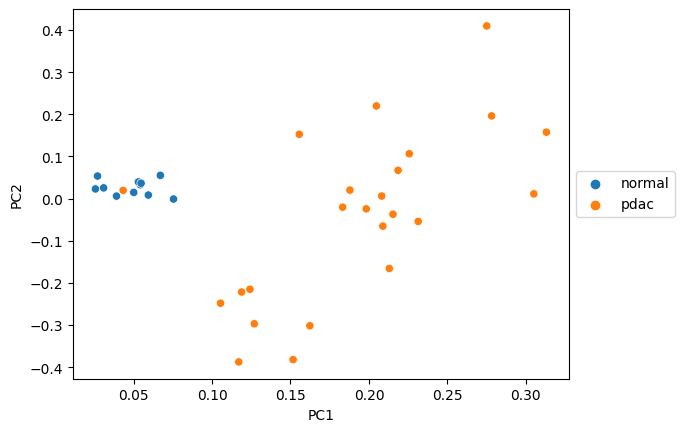

In [9]:
AaccPDAC.make_pca()
sns.scatterplot(x=AaccPDAC.Cs['PCA'][0],y=AaccPDAC.Cs['PCA'][1],
                hue=pdata_metadata.loc[AaccPDAC.Cs['PCA'].index,'accLabel'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("PC1")
plt.ylabel("PC2")


### 4 Optimal Transport: Wasserstein

In this step we compute the graph-to-graph distance solving the Optimal Transport minimization problem. Note that, the Optimal Transport is done in two main steps: (1) we use the function **compute_cost()** to compute an edge-to-edge distance and (2) we use the edge weights and the cost to get a graph-to-graph distance matrix using **compute_wasserstein()**
```{python}
AaccPDAC.compute_cost_all() ## Run all the possible cost matrices
```

In [10]:
AaccPDAC.compute_cost(mode='HTD') # Computing the cost
AaccPDAC.compute_wassestein(cost='HTD_0.5') # Getting the sample-to-sample distance

##### Metric Evaluation using K-means and the original labels

In [11]:
dt=AaccPDAC.eval_all(y=pdata_metadata.loc[AaccPDAC.p.columns,'accLabel'].astype('category').cat.codes)

In [12]:
dt

{'HTD_0.5': {'ar': 1.0,
  'r': 1.0,
  'fm': 1.0,
  'afm': 1.0,
  'mi': 0.6224869206570488,
  'nmi': 1.0,
  'ami': 1.0,
  'npa': 1.0,
  'psi': 1.0,
  'spsi': 1.0,
  'nca': 1.0}}

### 5 Clustering using the graph-to-graph distance

Although K-medoids can also be used for clustering scACCorDiON patient-patient distance matrix, in the tutorial we focus in the usage of the K-Barycenters. This usage is motivated by the latent variables infered by K-Barycenters.

#### K-medoids can also be used for performing clustering

```{python}
km = kmedoids.KMedoids(n_clusters=3, method='fasterpam')
plt.figure(figsize=(6,5))
c = km.fit(AaccPDAC.wdist['HTD_0.5'].to_numpy())
```

### 5.1.1 Here we compute the K-barycenters

In [13]:
X =np.round(AaccPDAC.wdist['HTD_0.5'].loc[AaccPDAC.wdist['HTD_0.5'].index,AaccPDAC.wdist['HTD_0.5'].index],5)
clust,loss = [],[]
for _ in tqdm(range(100)):
    kmeans = actl.KBarycenters(k=3,init='++',random_state=_,max_iters=100)
    kmeans.fit(X,distr=AaccPDAC.p,cost=AaccPDAC.Cs['HTD_0.5'])
    clust.append(kmeans)
    loss.append(kmeans.err[-1])
ncls= clust[np.argmin(loss)]

100%|█████████████████████████████████████████| 100/100 [01:04<00:00,  1.54it/s]


### 5.1.2 Updating the distance matrix with the Barycenters

In [14]:
aux = ncls.centroids.to_dict()
for i in range(3):
    for j in range(i,3):
        if i!=j:
            aux[i][j] = ot.emd2(a=ncls.bary[i]/ncls.bary[i].sum(),
                                b=ncls.bary[j]/ncls.bary[j].sum(),M=AaccPDAC.Cs['HTD_0.5'])
            aux[j][i] = ot.emd2(a=ncls.bary[i]/ncls.bary[i].sum(),
                                b=ncls.bary[j]/ncls.bary[j].sum(),M=AaccPDAC.Cs['HTD_0.5'])
        else:
            aux[i][j] = 0
eux = pd.concat([AaccPDAC.wdist['HTD_0.5'],ncls.centroids],axis=1)
eux = pd.concat([eux,pd.DataFrame.from_dict(aux).T])
tmplab = ncls.flabels.tolist()
for i in [0,1,2]:
    tmplab.append(i) 

##### Defining the barycenters

In [15]:
tmpstl = ['0']*len(AaccPDAC.p.columns)+['1']*3

### 5.1.3 Computing the new embeddings and plotting the new data representation 

In [16]:
import phate

In [17]:
%matplotlib agg
emb1 = phate.PHATE(knn=8,knn_dist='precomputed',random_state=42)
emb1 = emb1.fit_transform(eux.to_numpy())
fs,axs = plt.subplots(1,2,figsize=(14,5))

Calculating PHATE...
  Running PHATE on precomputed distance matrix with 38 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 5
  Calculated optimal t in 0.01 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.03 seconds.


#### Prepare the embedding the barycenters and the colormap

In [18]:
barys = pd.DataFrame(ncls.bary,index=AaccPDAC.p.loc[list(AaccPDAC.expgraph.nodes()),:].index)
barys.reset_index(inplace=True)
barys[['u', 'v']] = barys['index'].str.split('$', expand=True)
cmapse =[plt.cm.Greens,plt.cm.Blues,plt.cm.Reds]
vtxcmap = {i[1]:plt.cm.tab10.colors[i[0]] for i in enumerate(AaccPDAC.nodes)}

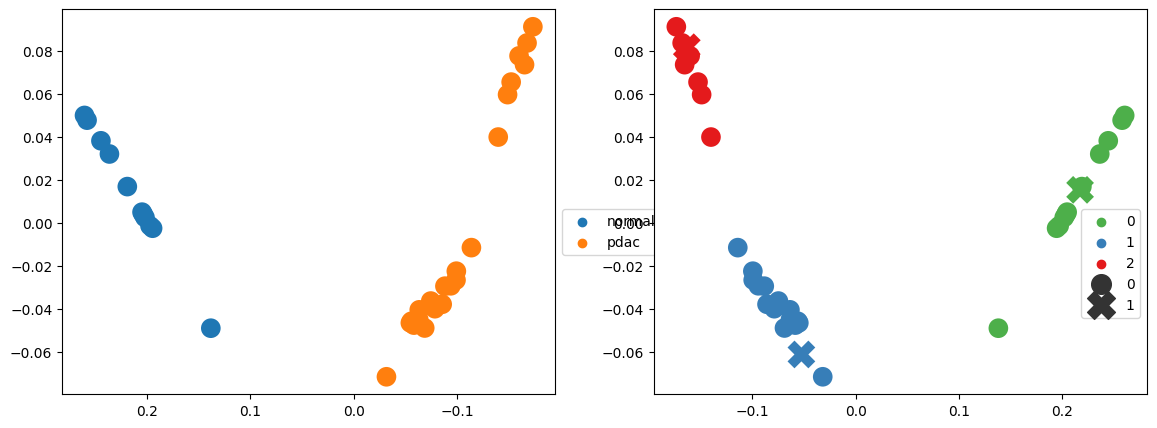

In [19]:
sns.scatterplot(x=emb1[0:-3,0],
                y=emb1[0:-3,1],hue=pdata_metadata.loc[AaccPDAC.Cs['PCA'].index,'accLabel'],s=200,linewidth=0,ax=axs[0])
axs[0].legend(loc=0, bbox_to_anchor=(1, 0.5))
axs[0].invert_xaxis()
sns.scatterplot(x=emb1[:,0],
                y=emb1[:,1],hue=tmplab,s=200,style=tmpstl,palette=list(plt.cm.Set1.colors)[0:3][::-1],
                size=tmpstl,sizes=(400,200),linewidth=0,ax=axs[1])
axs[1].legend(loc=0, bbox_to_anchor=(1, 0.5))
#axs[1].invert_xaxis()
fs

### 5.1.3 Barycenter CCC plots

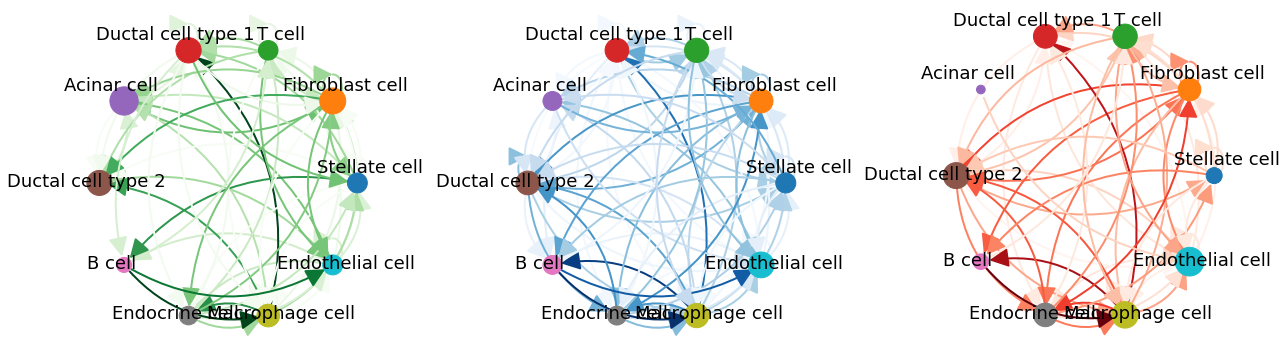

In [20]:
fs,axs = plt.subplots(1,3,figsize=(18,5),dpi=72)
axs = axs.ravel()
cnt=0
for i in [0,1,2]:
    barynet =nx.from_pandas_edgelist(barys[barys[i]>1e-5].sort_values(i,ascending=True),
                            source='u',
                            target='v',
                            edge_attr=i,
                            create_using=nx.DiGraph)
    tempnet = nx.complete_graph(len(AaccPDAC.nodes),create_using=nx.DiGraph)
    pos = nx.circular_layout(tempnet,scale=2)
    pos = {list(AaccPDAC.nodes)[i[0]]:i[1] for i in enumerate(pos.values())}
    for id1 in AaccPDAC.nodes:
        if  id1 not in barynet.nodes():
            barynet.add_node(id1)
    plt.figure(figsize=(5,5))
    currcmap = [vtxcmap[u] for u in barynet.nodes()]
    nsz=[i*5000 for i in list(nx.pagerank(barynet).values())]
    nx.draw_networkx_nodes(barynet,pos,node_size=nsz,node_color=currcmap,ax=axs[cnt])
    edcol = nx.get_edge_attributes(barynet,i)
    nx.draw_networkx_edges(barynet,pos=pos,edge_color=edcol.values(),
                           connectionstyle="arc3,rad=0.30",
                           edge_cmap=cmapse[i],width=2,ax=axs[cnt],arrowsize=40)
    for k,v in pos.items():
        v[1]+=np.sign(v[1])*0.1
        v[0]+=np.sign(v[0])*0.2
    nx.draw_networkx_labels(barynet,pos,verticalalignment='bottom',
                            font_size=18,clip_on=False,ax=axs[cnt])
    axs[cnt].axis('off')
    cnt+=1
    #plt.savefig(f'bary_{i}.pdf')
fs.tight_layout()
fs
#fs.savefig("../../Accordion_Experiments/Revision_Figure_Folder/ccis.pdf")

In [21]:
# fs,axs = plt.subplots(1,3,figsize=(18,5),dpi=72)
# axs = axs.ravel()
# cnt=0
# for i in [0,1,2]:
#     barynet =nx.from_pandas_edgelist(barys[barys[i]>1e-5].sort_values(i,ascending=True),
#                             source='u',
#                             target='v',
#                             edge_attr=i,
#                             create_using=nx.DiGraph)
#     tempnet = nx.complete_graph(len(AaccPDAC.nodes),create_using=nx.DiGraph)
#     pos = nx.circular_layout(tempnet,scale=2)
#     pos = {list(AaccPDAC.nodes)[i[0]]:i[1] for i in enumerate(pos.values())}
#     for id1 in AaccPDAC.nodes:
#         if  id1 not in barynet.nodes():
#             barynet.add_node(id1)
#     plt.figure(figsize=(5,5))
#     currcmap = [vtxcmap[u] for u in barynet.nodes()]
#     nsz=[i*5000 for i in list(nx.pagerank(barynet).values())]
#     nx.draw_networkx_nodes(barynet,pos,node_size=nsz,node_color=currcmap,ax=axs[cnt])
#     edcol = nx.get_edge_attributes(barynet,i)
#     nx.draw_networkx_edges(barynet,pos=pos,edge_color=edcol.values(),
#                            connectionstyle="arc3,rad=0.30",
#                            edge_cmap=cmapse[i],width=2,ax=axs[cnt],arrowsize=40)
#     for k,v in pos.items():
#         v[1]+=np.sign(v[1])*0.1
#         v[0]+=np.sign(v[0])*0.2
#     nx.draw_networkx_labels(barynet,pos,verticalalignment='bottom',
#                             font_size=18,clip_on=False,ax=axs[cnt])
#     axs[cnt].axis('off')
#     cnt+=1
#     #plt.savefig(f'bary_{i}.pdf')
# fs.tight_layout()
# fs
# # fs.savefig("../../Accordion_Experiments/Revision_Figure_Folder/ccis.pdf")

### 5.1.4 Looking into the Barycenter-Barycenter Transport Maps

In [22]:
ctrb2pdac1 = ot.emd(a=barys[0].to_numpy(),
       b=barys[1].to_numpy(),M=AaccPDAC.Cs['HTD_0.5'])
pdac12pdac2 = ot.emd(a=barys[1].to_numpy(),
       b=barys[2].to_numpy(),M=AaccPDAC.Cs['HTD_0.5'])
ctrb2pdac1 = ctrb2pdac1/ctrb2pdac1.max()
pdac12pdac2 = pdac12pdac2/pdac12pdac2.max()

# 5.1.5 Performing the interaction interaction se

In [23]:
def sel(x,n):
    end=((n**2)+n)/2
    print(end)
    return x[0:int(end)]
tmaps = pd.DataFrame.from_records([sel(ctrb2pdac1.ravel(),len(AaccPDAC.p)),
                                   sel(pdac12pdac2.ravel(),len(AaccPDAC.p))]).T
tmaps.index=list(it.combinations_with_replacement(AaccPDAC.p.index,2))
tmaps.columns = ['ctr->PDAC1','PDAC1->PDAC2']
maps = tmaps[tmaps.sum(axis=1)!=0]
tmaps=tmaps.reset_index()
tmaps[['edge1','edge2']] = pd.DataFrame(tmaps['index'].tolist())
tmaps[['source1','target1']] = tmaps['edge1'].str.split('$',expand=True)
tmaps[['source2','target2']] = tmaps['edge2'].str.split('$',expand=True)

3240.0
3240.0


In [ ]:
f,axs1 = plt.subplots(1,1,figsize=(6 ,5))
sns.regplot(x="ctr->PDAC1",y="PDAC1->PDAC2",data=tmaps,fit_reg = False,
           x_jitter = 0.001, y_jitter = 0.001, scatter_kws = {'alpha' : 1,'s':80},ax=axs1)
n=10
ssource = tmaps.loc[tmaps['source1']==tmaps['source2'],:].sort_values("ctr->PDAC1",ascending=False)
starget =  tmaps.loc[tmaps['target1']==tmaps['target2'],:].sort_values("PDAC1->PDAC2",ascending=False)

def ann(row):
    r = row[1]
    ind = r["index"]
    axs1.annotate(ind, xy=(r["ctr->PDAC1"], r["PDAC1->PDAC2"]), 
            xytext=(0.1,0.1) , textcoords ="offset points")

for row in ssource.iterrows():
    ann(row)
for row in starget.iterrows():
    ann(row)
axs1.set_xlabel('CONTROL1 -> PDAC1')
axs1.set_ylabel('PDAC1 -> PDAC2')
f
#f.savefig('../figs/tmap1.pdfSpatialDM')

In [ ]:
tmaps['selected'] = False
tmaps['selected'][starget.index[0]] = True
tmaps['selected'][ssource.index[6]] = True

In [ ]:
tmaps.sort_values(by=["ctr->PDAC1","PDAC1->PDAC2"])

In [ ]:
f,axs1 = plt.subplots(1,1,figsize=(6 ,5))
sns.regplot(x="ctr->PDAC1",y="PDAC1->PDAC2",data=tmaps,fit_reg = False,
           x_jitter = 0.001, y_jitter = 0.001, scatter_kws = {'alpha' : 1,'s':80},ax=axs1)
n=10
ssource = tmaps.loc[tmaps['source1']==tmaps['source2'],:].sort_values("ctr->PDAC1",ascending=False)
starget =  tmaps.loc[tmaps['target1']==tmaps['target2'],:].sort_values("PDAC1->PDAC2",ascending=False)

def ann(row):
    r = row[1]
    ind = r["index"]
    if r['selected']:
        axs1.annotate(ind, xy=(r["ctr->PDAC1"], r["PDAC1->PDAC2"]), 
                xytext=(0.1,0.1) , textcoords ="offset points")

for row in ssource.iterrows():
    ann(row)
for row in starget.iterrows():
    ann(row)
axs1.set_xlabel('CONTROL1 -> PDAC1')
axs1.set_ylabel('PDAC1 -> PDAC2')
f
#f.savefig('../figs/tmap1.pdf')

In [ ]:
tmaps.loc[tmaps['edge1'].isin(["Endothelial cell$Fibroblast cell"]),:]

In [ ]:
tmaps.loc[tmaps['edge1'].isin([""]),:]

In [ ]:
import scaccordion

In [ ]:
print(scaccordion.__version__)